## Libraries

In [ ]:
pip install pandasql openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# for image processing
import os
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

## 3rd part - sql query system
import pandasql as ps
import ipywidgets as widgets
from IPython.display import display, clear_output


## mounting the data from google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# original folder pics
# data_path="/content/drive/MyDrive/p1"

# updated folder pics
shade="/content/drive/MyDrive/data_science_project/shaded"
shade = [os.path.join(shade, f) for f in os.listdir(shade) if f.endswith('.png')]
clear="/content/drive/MyDrive/data_science_project/cleared"
clear = [os.path.join(clear, f) for f in os.listdir(clear) if f.endswith('.png')]
print(shade)
print(clear)


['/content/drive/MyDrive/data_science_project/shaded/shade_1.png', '/content/drive/MyDrive/data_science_project/shaded/shade_2.png', '/content/drive/MyDrive/data_science_project/shaded/shade_3.png', '/content/drive/MyDrive/data_science_project/shaded/shade_4.png', '/content/drive/MyDrive/data_science_project/shaded/shade_5.png', '/content/drive/MyDrive/data_science_project/shaded/shade_6.png', '/content/drive/MyDrive/data_science_project/shaded/shade_7.png', '/content/drive/MyDrive/data_science_project/shaded/shade_8.png', '/content/drive/MyDrive/data_science_project/shaded/shade_9.png', '/content/drive/MyDrive/data_science_project/shaded/shade_10.png', '/content/drive/MyDrive/data_science_project/shaded/shade_11.png', '/content/drive/MyDrive/data_science_project/shaded/shade_12.png', '/content/drive/MyDrive/data_science_project/shaded/shade_13.png', '/content/drive/MyDrive/data_science_project/shaded/shade_14.png', '/content/drive/MyDrive/data_science_project/shaded/shade_15.png', '/c

## sample images

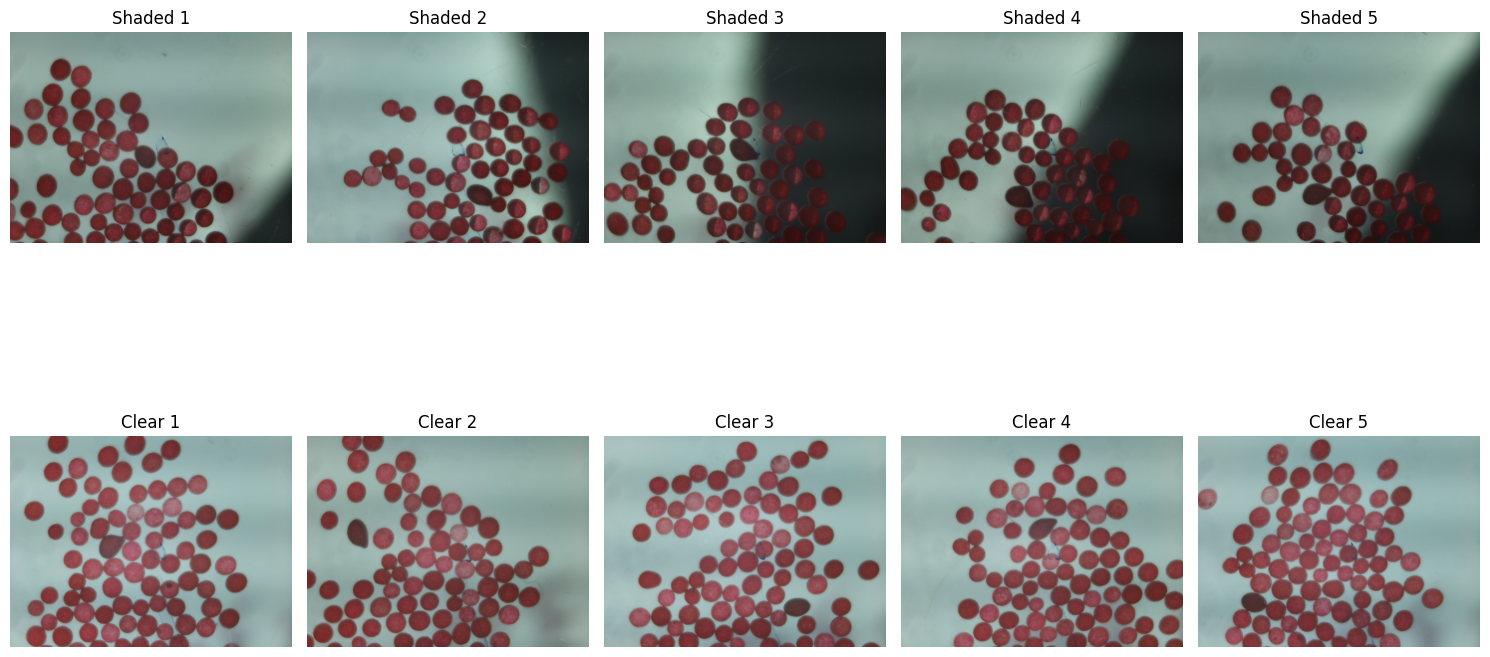

In [ ]:
shade_images = shade[:5]
clear_images = clear[:5]

# Display images
plt.figure(figsize=(15, 10))

# Loop to display images from both folders
for i in range(5):
    # Load the images
    shade_image = cv2.imread(shade_images[i])
    clear_image = cv2.imread(clear_images[i])

    # Convert images to RGB format (OpenCV uses BGR by default)
    shade_image_rgb = cv2.cvtColor(shade_image, cv2.COLOR_BGR2RGB)
    clear_image_rgb = cv2.cvtColor(clear_image, cv2.COLOR_BGR2RGB)

    # Displaying images from shaded folder
    plt.subplot(2, 5, i+1)
    plt.imshow(shade_image_rgb)
    plt.axis('off')
    plt.title(f"Shaded {i+1}")

    # Displaying images from clear folder
    plt.subplot(2, 5, i+6)
    plt.imshow(clear_image_rgb)
    plt.axis('off')
    plt.title(f"Clear {i+1}")

plt.tight_layout()
plt.show()


# Image Analysis and Feature Extraction:

## clear pics code

In [ ]:
def process_clear(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Enhanced pipeline for regular images
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    combined_thresh = cv2.bitwise_or(adaptive_thresh, otsu_thresh)

    # Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(combined_thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Watershed algorithm
    dist_transform = cv2.distanceTransform(closed, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = cv2.dilate(closed, kernel, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    watershed_image = image.copy()
    markers = cv2.watershed(watershed_image, markers)
    watershed_image[markers == -1] = [255, 0, 0]

    # Count and analyze cells
    cell_count = 0
    image_area = image.shape[0] * image.shape[1]  # Total image area
    cell_data = []  # List to store cell data

    for label in range(2, markers.max() + 1):  # Skip background
        mask = (markers == label).astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            area = cv2.contourArea(contour)
            if 200 < area < 5000:  # Adjust area thresholds
                cell_count += 1
                M = cv2.moments(contour)
                centroid_x = int(M["m10"] / M["m00"]) if M["m00"] != 0 else 0
                centroid_y = int(M["m01"] / M["m00"]) if M["m00"] != 0 else 0

                # Calculate perimeter and circularity
                perimeter = cv2.arcLength(contour, True)
                circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

                # Shape factor
                shape_factor = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0

                # Density
                density = cell_count / image_area  # Cells per pixel

                # Store cell data
                cell_data.append([area, centroid_x, centroid_y, circularity, shape_factor, density])

                # Draw contours on the image
                cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

    return image, combined_thresh, dist_transform, sure_fg, markers, cell_count, cell_data

### single image

      Area  Centroid_X  Centroid_Y  Circularity  Shape Factor   Density
0   2664.0         473          59     0.892419      1.120549  0.000002
1   2267.5         403          91     0.873520      1.144794  0.000004
2   2513.0         583         125     0.837633      1.193841  0.000006
3   2518.0         644         127     0.822273      1.216142  0.000008
4   2243.0         459         135     0.889365      1.124397  0.000010
..     ...         ...         ...          ...           ...       ...
67  2378.0         421         573     0.810418      1.233931  0.000142
68  1146.5         584         587     0.618133      1.617775  0.000144
69   926.5         667         588     0.666345      1.500724  0.000146
70   653.0         479         590     0.530027      1.886697  0.000148
71   297.5         230         593     0.433456      2.307037  0.000150

[72 rows x 6 columns]


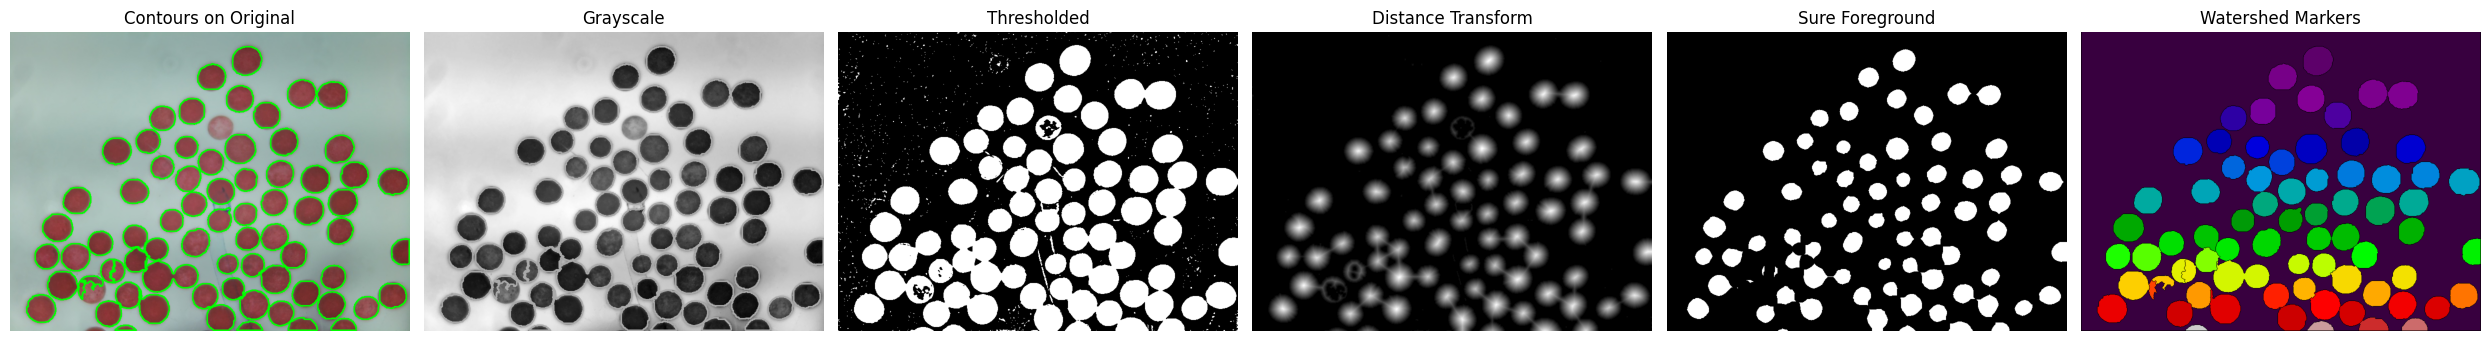

In [ ]:
# Test on a single image (for testing purposes)
single_image_path = "/content/drive/MyDrive/data_science_project/cleared/clear_56.png"  # Update path to your image
image = cv2.imread(single_image_path)

# Process the image
processed_image, combined_thresh, dist_transform, sure_fg, markers, cell_count, cell_data = process_clear(image)

# Convert results to DataFrame for easy printing
df = pd.DataFrame(cell_data, columns=["Area", "Centroid_X", "Centroid_Y", "Circularity", "Shape Factor", "Density"])

# Display the DataFrame
print(df)

# Plot images for debugging
fig, ax = plt.subplots(1, 6, figsize=(25, 5))
ax[0].imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Contours on Original")
ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap='gray')
ax[1].set_title("Grayscale")
ax[2].imshow(combined_thresh, cmap='gray')
ax[2].set_title("Thresholded")
ax[3].imshow(dist_transform if dist_transform is not None else np.zeros_like(combined_thresh), cmap='gray')
ax[3].set_title("Distance Transform")
ax[4].imshow(sure_fg if sure_fg is not None else np.zeros_like(combined_thresh), cmap='gray')
ax[4].set_title("Sure Foreground")
ax[5].imshow(markers if markers is not None else np.zeros_like(combined_thresh), cmap='nipy_spectral')
ax[5].set_title("Watershed Markers")

for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()


### whole folder

Processing Image 1/73: /content/drive/MyDrive/data_science_project/cleared/clear_1.png
Processing Image 2/73: /content/drive/MyDrive/data_science_project/cleared/clear_2.png
Processing Image 3/73: /content/drive/MyDrive/data_science_project/cleared/clear_3.png
Processing Image 4/73: /content/drive/MyDrive/data_science_project/cleared/clear_4.png
Processing Image 5/73: /content/drive/MyDrive/data_science_project/cleared/clear_5.png
Processing Image 6/73: /content/drive/MyDrive/data_science_project/cleared/clear_6.png
Processing Image 7/73: /content/drive/MyDrive/data_science_project/cleared/clear_7.png
Processing Image 8/73: /content/drive/MyDrive/data_science_project/cleared/clear_8.png
Processing Image 9/73: /content/drive/MyDrive/data_science_project/cleared/clear_9.png
Processing Image 10/73: /content/drive/MyDrive/data_science_project/cleared/clear_10.png
Processing Image 11/73: /content/drive/MyDrive/data_science_project/cleared/clear_11.png
Processing Image 12/73: /content/drive/

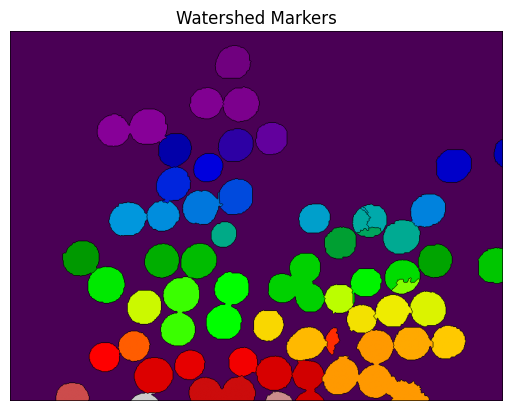

In [ ]:
# Function to process all images in a folder and save results
folder_path = "/content/drive/MyDrive/data_science_project/cleared"
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

cell_data_list = []
summary_data_list = []

for i, path in enumerate(images):
    print(f"Processing Image {i+1}/{len(images)}: {path}")
    image = cv2.imread(path)
    # Process the image
    processed_image, combined_thresh, dist_transform, sure_fg, markers, cell_count, cell_data = process_clear(image)

    # Store cell-level data
    for cell in cell_data:
        cell_data_list.append([os.path.basename(path)] + cell)

    # Store summary statistics
    areas = [c[0] for c in cell_data]  # Extract areas
    circularities = [c[3] for c in cell_data]  # Extract circularities
    mean_area = np.mean(areas) if areas else 0
    mean_circularity = np.mean(circularities) if circularities else 0

    # Classify distribution pattern based on cell count
    if cell_count < 15:
        dist_pattern = "Sparse"
    elif 15 <= cell_count <= 55:
        dist_pattern = "Moderate"
    else:
        dist_pattern = "Dense"

    summary_data_list.append([os.path.basename(path), mean_area, cell_count, mean_circularity, dist_pattern])

# Defining data types
dtype_cells = {
    "Image": "string",
    "Area": "float32",
    "Centroid_X": "int32",
    "Centroid_Y": "int32",
    "Circularity": "float32",
    "Shape_Factor": "float32",
    "Density": "float32"
}

dtype_summary = {
    "Image": "string",
    "Mean_Area": "float32",
    "Cell_Count": "int32",
    "Mean_Circularity": "float32",
    "Distribution_Pattern": "category"
}

# Convert lists to DataFrames with specific dtypes
df_ccells = pd.DataFrame(cell_data_list, columns=dtype_cells.keys()).astype(dtype_cells)
df_cimages = pd.DataFrame(summary_data_list, columns=dtype_summary.keys()).astype(dtype_summary)

# Displaying the last processed image
plt.imshow(markers if markers is not None else np.zeros_like(combined_thresh), cmap='nipy_spectral')
plt.title("Watershed Markers")
plt.axis("off")
plt.show()

## shady pics code

In [ ]:
def process_shade(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Brighten dark regions using gamma correction
    gamma = 3
    invGamma = 1.0 / gamma
    lookUpTable = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    brightened_image = cv2.LUT(gray_image, lookUpTable)

    # Step 2: Gaussian Blur
    blurred_image = cv2.GaussianBlur(brightened_image, (5, 5), 0)

    # Step 3: Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(16, 16))
    enhanced_image = clahe.apply(blurred_image)

    # Step 4: Median Blur
    denoised_image = cv2.medianBlur(enhanced_image, 5)

    # Step 5: Canny Edge Detection
    edges_image = cv2.Canny(denoised_image, 35, 50)

    # Step 6: Distance Transform for Watershed
    dist_transform = cv2.distanceTransform(edges_image, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Step 7: Sure Background
    kernel = np.ones((3, 3), np.uint8)
    sure_bg = cv2.dilate(edges_image, kernel, iterations=3)

    # Step 8: Unknown Region
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 9: Marker Labeling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Step 10: Apply Watershed
    watershed_image = image.copy()
    markers = cv2.watershed(watershed_image, markers)
    watershed_image[markers == -1] = [255, 0, 0]

    # Step 11: Extract Cell Properties
    cell_data = []
    cell_count = 0
    image_area = image.shape[0] * image.shape[1]  # Total image area

    for label in range(2, markers.max() + 1):
        mask = (markers == label).astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv2.contourArea(contour)
            if area < 100:  # Ignore small noise
                continue

            cell_count += 1
            M = cv2.moments(contour)
            centroid_x = int(M["m10"] / M["m00"]) if M["m00"] != 0 else 0
            centroid_y = int(M["m01"] / M["m00"]) if M["m00"] != 0 else 0

            perimeter = cv2.arcLength(contour, True)
            circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
            shape_factor = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0  # Shape descriptor
            density = cell_count / image_area  # Cells per pixel

            cell_data.append([area, centroid_x, centroid_y, circularity, shape_factor, density])

    return gray_image, brightened_image, enhanced_image, denoised_image, edges_image, watershed_image, cell_count, cell_data

### single image

      Area  Centroid_X  Centroid_Y  Circularity  Shape Factor   Density
0    131.0         467         164     0.012458     80.267308  0.000002
1   2164.0         312         171     0.885970      1.128707  0.000004
2   2130.0         370         173     0.895853      1.116255  0.000006
3    132.5         444         190     0.021215     47.136059  0.000008
4    130.5         434         178     0.198857      5.028730  0.000010
5   1875.5         556         219     0.891316      1.121937  0.000013
6    194.5         540         220     0.189265      5.283601  0.000015
7    129.0         440         231     0.019947     50.133551  0.000017
8    238.5         454         222     0.084123     11.887384  0.000019
9    114.5         608         236     0.033614     29.749680  0.000021
10   129.0         493         255     0.013397     74.641240  0.000023
11   103.0         610         254     0.244426      4.091215  0.000025
12  2153.0         580         296     0.888413      1.125603  0

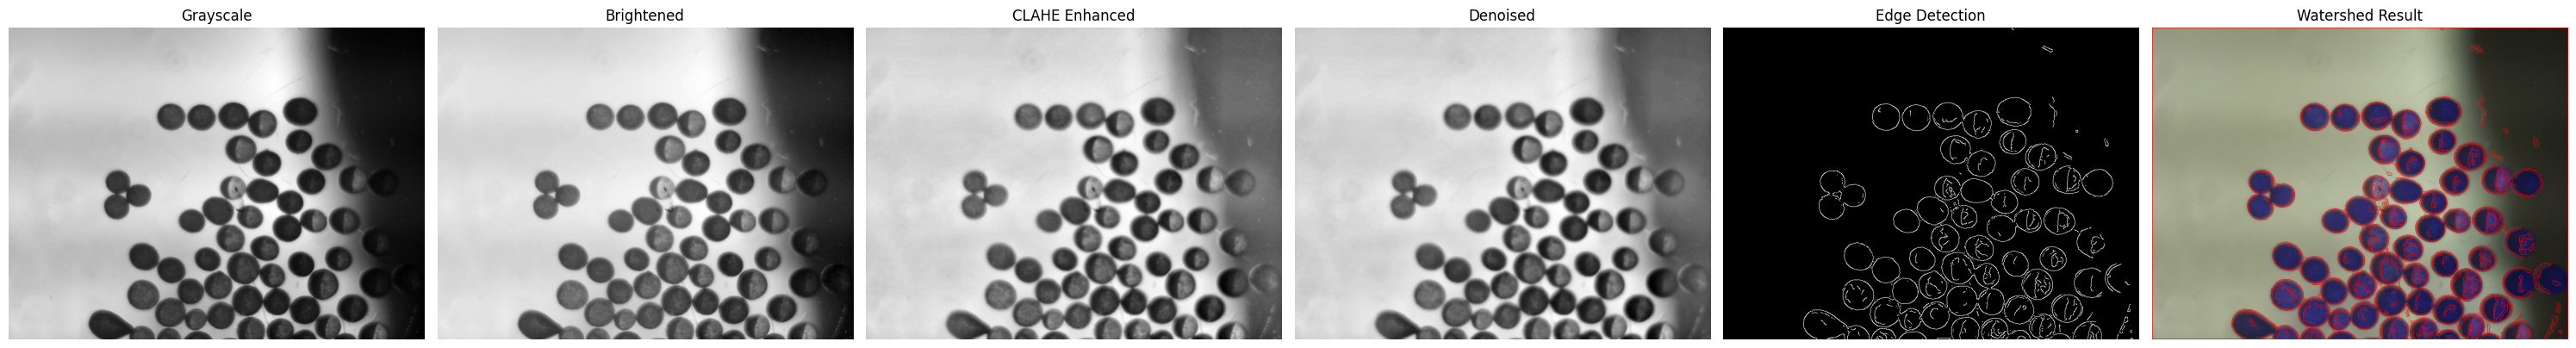

In [ ]:
single_image = "/content/drive/MyDrive/data_science_project/shaded/shade_12.png"

image = cv2.imread(single_image)
gray, bright, enhanced, denoised, edges, watershed, cell_count, cell_data = process_shade(image)

# Convert results to dataframe for easy printing
df_shade = pd.DataFrame(cell_data, columns=["Area", "Centroid_X", "Centroid_Y", "Circularity", "Shape Factor", "Density"])
print(df_shade)

print(f"Total Cells Detected: {cell_count}")

# Display images
fig, ax = plt.subplots(1, 6, figsize=(30, 5))
ax[0].imshow(gray, cmap='gray'); ax[0].set_title("Grayscale")
ax[1].imshow(bright, cmap='gray'); ax[1].set_title("Brightened")
ax[2].imshow(enhanced, cmap='gray'); ax[2].set_title("CLAHE Enhanced")
ax[3].imshow(denoised, cmap='gray'); ax[3].set_title("Denoised")
ax[4].imshow(edges, cmap='gray'); ax[4].set_title("Edge Detection")
ax[5].imshow(watershed); ax[5].set_title("Watershed Result")

for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()


### whole folder

In [ ]:
# Function to process all images in a folder and save results
folder_path = "/content/drive/MyDrive/data_science_project/shaded"
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

cell_data_list = []
summary_data_list = []

for i, path in enumerate(images):
    print(f"Processing Image {i+1}/{len(images)}: {path}")
    image = cv2.imread(path)
    _, _, _, _, _, _, cell_count, cell_data = process_shade(image)

    # Store cell-level data
    for cell in cell_data:
        cell_data_list.append([os.path.basename(path)] + cell)

    # Store summary statistics
    areas = [c[0] for c in cell_data]  # Extract areas
    circularities = [c[3] for c in cell_data]  # Extract circularities
    mean_area = np.mean(areas) if areas else 0
    mean_circularity = np.mean(circularities) if circularities else 0

    # Classify distribution pattern based on cell count
    if cell_count < 10:
        dist_pattern = "Sparse"
    elif 10 <= cell_count <= 50:
        dist_pattern = "Moderate"
    else:
        dist_pattern = "Dense"

    summary_data_list.append([os.path.basename(path), mean_area, cell_count, mean_circularity, dist_pattern])

# Defining data types
dtype_cells = {
    "Image": "string",
    "Area": "float32",
    "Centroid_X": "int32",
    "Centroid_Y": "int32",
    "Circularity": "float32",
    "Shape_Factor": "float32",
    "Density": "float32"
}

dtype_summary = {
    "Image": "string",
    "Mean_Area": "float32",
    "Cell_Count": "int32",
    "Mean_Circularity": "float32",
    "Distribution_Pattern": "category"
}

# Convert lists to DataFrames with specific dtypes
df_scells = pd.DataFrame(cell_data_list, columns=dtype_cells.keys()).astype(dtype_cells)
df_simages = pd.DataFrame(summary_data_list, columns=dtype_summary.keys()).astype(dtype_summary)

Processing Image 1/63: /content/drive/MyDrive/data_science_project/shaded/shade_1.png
Processing Image 2/63: /content/drive/MyDrive/data_science_project/shaded/shade_2.png
Processing Image 3/63: /content/drive/MyDrive/data_science_project/shaded/shade_3.png
Processing Image 4/63: /content/drive/MyDrive/data_science_project/shaded/shade_4.png
Processing Image 5/63: /content/drive/MyDrive/data_science_project/shaded/shade_5.png
Processing Image 6/63: /content/drive/MyDrive/data_science_project/shaded/shade_6.png
Processing Image 7/63: /content/drive/MyDrive/data_science_project/shaded/shade_7.png
Processing Image 8/63: /content/drive/MyDrive/data_science_project/shaded/shade_8.png
Processing Image 9/63: /content/drive/MyDrive/data_science_project/shaded/shade_9.png
Processing Image 10/63: /content/drive/MyDrive/data_science_project/shaded/shade_10.png
Processing Image 11/63: /content/drive/MyDrive/data_science_project/shaded/shade_11.png
Processing Image 12/63: /content/drive/MyDrive/dat

# Data Transformation and Tabular Format:

### Organize the extracted cell-level and image-level data into a well-structured tabular format.

In [ ]:
## clear
print(df_ccells.info())
print(df_cimages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4279 entries, 0 to 4278
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Image         4279 non-null   string 
 1   Area          4279 non-null   float32
 2   Centroid_X    4279 non-null   int32  
 3   Centroid_Y    4279 non-null   int32  
 4   Circularity   4279 non-null   float32
 5   Shape_Factor  4279 non-null   float32
 6   Density       4279 non-null   float32
dtypes: float32(4), int32(2), string(1)
memory usage: 133.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Image                 73 non-null     string  
 1   Mean_Area             73 non-null     float32 
 2   Cell_Count            73 non-null     int32   
 3   Mean_Circularity      73 non-null     float32 
 4   Distribution_Pattern

In [ ]:
## shade
print(df_scells.info())
print(df_simages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Image         2853 non-null   string 
 1   Area          2853 non-null   float32
 2   Centroid_X    2853 non-null   int32  
 3   Centroid_Y    2853 non-null   int32  
 4   Circularity   2853 non-null   float32
 5   Shape_Factor  2853 non-null   float32
 6   Density       2853 non-null   float32
dtypes: float32(4), int32(2), string(1)
memory usage: 89.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Image                 63 non-null     string  
 1   Mean_Area             63 non-null     float32 
 2   Cell_Count            63 non-null     int32   
 3   Mean_Circularity      63 non-null     float32 
 4   Distribution_Pattern 

In [ ]:
print("Descriptive Stats of Clear Cells: \n")
df_ccells.describe()

Descriptive Stats of Clear Cells: 



,Area,Centroid_X,Centroid_Y,Circularity,Shape_Factor,Density
count,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000
mean,2060.735107,378.733115,389.655761,0.762175,1.413253,0.000066
std,692.982971,178.080416,144.619812,0.155324,0.591688,0.000040
min,201.500000,4.000000,3.000000,0.066641,1.094681,0.000002
25%,1730.500000,247.000000,283.500000,0.717318,1.151411,0.000033
50%,2131.000000,377.000000,409.000000,0.829545,1.205480,0.000065
75%,2475.750000,509.000000,514.000000,0.868500,1.394082,0.000097
max,4945.500000,793.000000,594.000000,0.913508,15.005865,0.000173


In [ ]:
print("Descriptive Stats of Shade Cells: \n")
df_scells.describe()

Descriptive Stats of Shade Cells: 



,Area,Centroid_X,Centroid_Y,Circularity,Shape_Factor,Density
count,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000
mean,617.745544,440.074658,421.771819,0.250174,22.948174,0.000050
std,1016.923340,157.727637,114.165219,0.294824,36.011421,0.000030
min,100.000000,16.000000,72.000000,0.003159,1.103769,0.000002
25%,123.500000,328.000000,340.000000,0.047516,2.961534,0.000025
50%,159.500000,455.000000,436.000000,0.105460,9.482229,0.000048
75%,289.000000,555.000000,520.000000,0.337663,21.045477,0.000073
max,10181.000000,793.000000,594.000000,0.905987,316.515137,0.000140


In [ ]:
print("Descriptive Stats of Clear Images: \n")
df_cimages.describe()

Descriptive Stats of Clear Images: 



,Mean_Area,Cell_Count,Mean_Circularity
count,73.000000,73.000000,73.000000
mean,2023.337280,58.616438,0.742251
std,374.530823,15.174568,0.128735
min,0.000000,0.000000,0.000000
25%,1997.645874,54.000000,0.741699
50%,2056.661377,59.000000,0.763128
75%,2153.573730,67.000000,0.784157
max,2791.750000,83.000000,0.815422


In [ ]:
print("Descriptive Stats of Shade Images: \n")
df_simages.describe()

Descriptive Stats of Shade Images: 



,Mean_Area,Cell_Count,Mean_Circularity
count,63.000000,63.000000,63.000000
mean,632.588362,45.285714,0.251293
std,285.012463,7.870788,0.074380
min,236.712128,21.000000,0.137477
25%,410.791656,42.000000,0.195122
50%,544.386353,44.000000,0.235562
75%,847.595001,50.000000,0.302311
max,1444.416626,67.000000,0.486481


In [ ]:
df_ccells.head(5)
df_cimages.head(5)

,Image,Mean_Area,Cell_Count,Mean_Circularity,Distribution_Pattern
0,clear_1.png,1910.160034,75,0.710259,Dense
1,clear_2.png,1832.776978,74,0.728936,Dense
2,clear_3.png,1986.911377,79,0.721597,Dense
3,clear_4.png,1920.140015,75,0.761624,Dense
4,clear_5.png,1797.933716,83,0.641540,Dense


In [ ]:
df_scells.head(5)
df_simages.head(5)

,Image,Mean_Area,Cell_Count,Mean_Circularity,Distribution_Pattern
0,shade_1.png,1009.767456,43,0.331762,Moderate
1,shade_2.png,726.727295,44,0.279889,Moderate
2,shade_3.png,505.228271,46,0.206280,Moderate
3,shade_4.png,622.636353,44,0.238177,Moderate
4,shade_5.png,1070.117676,34,0.222152,Moderate


### merging them in 1 excel file

In [ ]:
with pd.ExcelWriter("/content/drive/MyDrive/data_science_project/images_analysis.xlsx") as writer:
    df_ccells.to_excel(writer, sheet_name="clear_cell_level", index=False)
    df_cimages.to_excel(writer, sheet_name="clear_image_level", index=False)
    df_scells.to_excel(writer, sheet_name="shade_cell_level", index=False)
    df_simages.to_excel(writer, sheet_name="shade_image_level", index=False)

print("File created!")


File created!


# Interactive Query and Analysis Tool:

Dropdown(description='Examples:', layout=Layout(width='100%'), options=('SELECT COUNT(*) FROM df_ccells;', 'SE…

Textarea(value='SELECT Circularity FROM df_scells;\n', description='Query:', layout=Layout(height='100px', wid…

Button(button_style='primary', description='Run Query', style=ButtonStyle())

Dropdown(description='Plot Type:', index=1, layout=Layout(width='50%'), options=('bar', 'histogram', 'scatter'…

,Circularity
0,0.884682
1,0.820354
2,0.004435
3,0.862678
4,0.009107
...,...
2848,0.052660
2849,0.098639
2850,0.104045
2851,0.164502


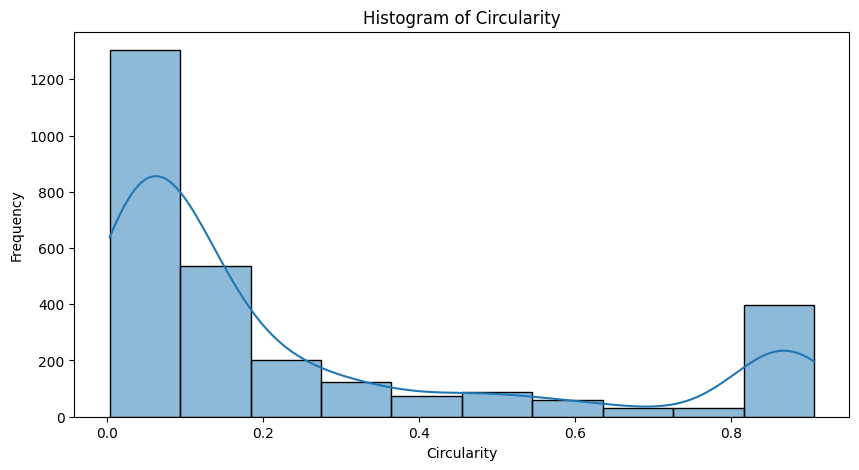

In [ ]:
# Load Excel file
xls_file = "/content/drive/MyDrive/data_science_project/images_analysis.xlsx"
df_ccells = pd.read_excel(xls_file, sheet_name="clear_cell_level")
df_cimages = pd.read_excel(xls_file, sheet_name="clear_image_level")
df_scells = pd.read_excel(xls_file, sheet_name="shade_cell_level")
df_simages = pd.read_excel(xls_file, sheet_name="shade_image_level")

datasets = {
    "df_ccells": df_ccells,
    "df_cimages": df_cimages,
    "df_scells": df_scells,
    "df_simages": df_simages
}

def run_sql_query(query):
    clear_output(wait=True)  # Clears previous output
    display(sample_queries, query_input, execute_button, plot_type_dropdown)

    try:
        result = ps.sqldf(query, datasets)
        if result.empty:
            print("⚠️ No results found.")
        else:
            display(result)
            plot_data(result)
    except Exception as e:
        print(f"❌ SQL Execution Error: {e}")

def plot_data(df):
    if df.empty:
        print("⚠️ No data to visualize.")
        return

    numeric_columns = df.select_dtypes(include=['number']).columns
    if len(numeric_columns) == 0:
        print("⚠️ No numeric columns found for plotting.")
        return

    selected_plot = plot_type_dropdown.value
    plt.figure(figsize=(10, 5))

    if selected_plot == "bar":
        x_column = df.columns[0]
        y_column = numeric_columns[0]
        sns.barplot(x=df[x_column], y=df[y_column])
        plt.xticks(rotation=45)
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.title(f"Bar Plot of {y_column} by {x_column}")

    elif selected_plot == "histogram":
        sns.histplot(df[numeric_columns[0]], bins=10, kde=True)
        plt.xlabel(numeric_columns[0])
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {numeric_columns[0]}")

    elif selected_plot == "scatter":
        if len(numeric_columns) > 1:
            sns.scatterplot(x=df[numeric_columns[0]], y=df[numeric_columns[1]])
            plt.xlabel(numeric_columns[0])
            plt.ylabel(numeric_columns[1])
            plt.title(f"Scatter Plot of {numeric_columns[1]} vs {numeric_columns[0]}")
        else:
            print("⚠️ Scatter plot requires at least two numeric columns.")

    elif selected_plot == "heatmap":
        if len(numeric_columns) > 1:
            sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
            plt.title("Heatmap of Numeric Features")
        else:
            print("⚠️ Heatmap requires multiple numeric columns.")

    plt.show()

query_input = widgets.Textarea(
    value='',
    placeholder='Enter SQL query using dataset names: df_ccells, df_cimages, df_scells, df_simages',
    description='Query:',
    layout=widgets.Layout(width='100%', height='100px')
)

execute_button = widgets.Button(description="Run Query", button_style='primary')

def on_execute_button_clicked(b):
    query = query_input.value.strip()
    if query:
        run_sql_query(query)
    else:
        print("⚠️ Please enter a valid SQL query.")

execute_button.on_click(on_execute_button_clicked)

sample_queries = widgets.Dropdown(
    options=[
        "SELECT COUNT(*) FROM df_ccells;",
        "SELECT Image, COUNT(*) AS cell_count FROM df_ccells GROUP BY Image ORDER BY cell_count DESC LIMIT 5;",
        "SELECT COUNT(*) FROM df_ccells WHERE Circularity BETWEEN 0.4 AND 0.6;"
    ],
    description="Examples:",
    layout=widgets.Layout(width='100%')
)

def on_sample_query_change(change):
    query_input.value = change['new']

sample_queries.observe(on_sample_query_change, names='value')

plot_type_dropdown = widgets.Dropdown(
    options=["bar", "histogram", "scatter", "heatmap"],
    value="bar",
    description="Plot Type:",
    layout=widgets.Layout(width='50%')
)

display(sample_queries, query_input, execute_button, plot_type_dropdown)
